In [2]:
import numpy as np
np.random.seed(0)
from keras.models import load_model
from keras.layers import Input, LSTM, RepeatVector,GRU
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_fscore_support,accuracy_score,recall_score,confusion_matrix,precision_score,f1_score

import pandas as pd

from sklearn.svm import SVC

C:\Users\aliye\Anaconda3\envs\Audeep\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def print_metrics(Y,predictions):
    acc=accuracy_score(Y,predictions)
    war=recall_score(Y,predictions,average="weighted")
    wap=precision_score(Y,predictions,average="weighted")
    waf1=f1_score(Y,predictions,average="weighted")
    print("Accuracy: ",acc)
    print("Recall: ",war)
    print("Precision: ",wap)
    print("F1-Score: ",waf1)
    a=confusion_matrix(Y,predictions)
    print("{0:.2f}\t{1:.2f}\t{2:.2f}\t{3:.2f}".format(acc*100,war*100,wap*100,waf1*100))
    return a


In [116]:
TRAIN =True
SAVE_FEATURES=True
CELL_TYPE="gru"
timesteps=256
latent_dim=256
window_length="0.16"
window_overlap="0.08"
def save_features(file_names,X,Y,csv_file):
    df=pd.DataFrame(X)
    df["files"]=file_names
    df["Class"]=Y
    df.to_csv("features/"+csv_file+".csv",index=False)
    
def extract_features(db):
    train_db=pd.read_csv("spectograms/MeanNormalized/heartbeat-"+window_length+"-"+window_overlap+"-128-"+db+".csv/train/heartbeat-"+window_length+"-"+window_overlap+"-128-"+db+".csv")
    val_db=pd.read_csv("spectograms/MeanNormalized/heartbeat-"+window_length+"-"+window_overlap+"-128-"+db+".csv/devel/heartbeat-"+window_length+"-"+window_overlap+"-128-"+db+".csv")
    class0=train_db[train_db["label_nominal"]==0]
    class1=train_db[train_db["label_nominal"]==1]
    class2=train_db[train_db["label_nominal"]==2]
    
    train_upsampled=pd.concat((class0,class0,class0,class1,class2,class2))
    train_upsampled=train_upsampled.reindex()
    train_Y=train_upsampled.label_nominal
    val_Y=val_db.label_nominal
    train_X=train_upsampled.iloc[:,4:]
    val_X=val_db.iloc[:,4:]
    print(len(train_X.columns))


    
    train_X=train_X.values.flatten().reshape(len(train_X),timesteps,187) #502,64,372
    input_dim=train_X.shape[2]
    
    inputs = Input(shape=(timesteps, input_dim))
    encoded = GRU(latent_dim)(inputs)

    decoded = RepeatVector(timesteps)(encoded)
    decoded = GRU(input_dim, return_sequences=True)(decoded)

    sequence_autoencoder = Model(inputs, decoded)
    
    encoder = Model(inputs, encoded) #hidden representations 
    if TRAIN:


        sequence_autoencoder.compile(optimizer='adam', loss='mse')
        early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)
        sequence_autoencoder.fit(train_X,train_X,batch_size=32,epochs=50,callbacks=[early_stop])
        sequence_autoencoder.save("models/upsample/"+CELL_TYPE+"/"+str(window_length)+"_"+str(window_overlap)+"/autoencoder_2layer_"+str(timesteps)+"_"+db+"_"+str(latent_dim)+".model")

    else :
        sequence_autoencoder=load_model("models/upsample/"+CELL_TYPE+"/"+str(window_length)+"_"+str(window_overlap)+"/autoencoder_2layer_"+str(timesteps)+"_"+db+"_"+str(latent_dim)+".model")
    features_train_X=encoder.predict(train_X)
    features_val_X=encoder.predict(val_X.values.reshape(len(val_X),timesteps,187))
    if SAVE_FEATURES:
        save_features(train_upsampled.filename.values,features_train_X,train_Y.values,CELL_TYPE+"/"+str(window_length)+"_"+str(window_overlap)+"/upsample_2layer_"+str(timesteps)+"_"+db+"_"+str(latent_dim)+"train")
        save_features(val_db.filename.values,features_val_X,val_Y.values,CELL_TYPE+"/"+str(window_length)+"_"+str(window_overlap)+"/upsample_2layer_"+str(timesteps)+"_"+db+"_"+str(latent_dim)+"val")
    return features_train_X,features_val_X,train_Y,val_Y

In [117]:

# all Y's are same
train_30_X,val_30_X,train_30_Y,val_30_Y=extract_features("30")
train_45_X,val_45_X,train_45_Y,val_45_Y=extract_features("45")
train_65_X,val_65_X,train_65_Y,val_65_Y=extract_features("65")
train_70_X,val_70_X,train_70_Y,val_70_Y=extract_features("70")
train_75_X,val_75_X,train_75_Y,val_75_Y=extract_features("75")
train_80_X,val_80_X,train_80_Y,val_80_Y=extract_features("80")
train_85_X,val_85_X,train_85_Y,val_85_Y=extract_features("85")
train_90_X,val_90_X,train_90_Y,val_90_Y=extract_features("90")
train_95_X,val_95_X,train_95_Y,val_95_Y=extract_features("95")






47872
Epoch 1/50
812/812 [==============================] - 22s 27ms/step - loss: 0.1469
Epoch 2/50
812/812 [==============================] - 16s 20ms/step - loss: 0.0530
Epoch 3/50
812/812 [==============================] - 16s 20ms/step - loss: 0.0519
Epoch 4/50
812/812 [==============================] - 16s 20ms/step - loss: 0.0509
Epoch 5/50
812/812 [==============================] - 16s 20ms/step - loss: 0.0502
Epoch 6/50
812/812 [==============================] - 16s 20ms/step - loss: 0.0496
Epoch 7/50
812/812 [==============================] - 17s 21ms/step - loss: 0.0491
Epoch 8/50
812/812 [==============================] - 17s 21ms/step - loss: 0.0487
Epoch 9/50
812/812 [==============================] - 17s 21ms/step - loss: 0.0485
Epoch 10/50
812/812 [==============================] - 17s 21ms/step - loss: 0.0483
Epoch 11/50
812/812 [==============================] - 17s 22ms/step - loss: 0.0482
Epoch 12/50
812/812 [==============================] - 17s 21ms/step - loss: 0.

In [109]:
47872/256

187.0

In [118]:


train_X=np.concatenate((train_30_X,train_45_X,train_60_X,train_70_X,train_75_X,train_80_X,train_85_X,train_90_X,train_95_X),axis=1)
val_X=np.concatenate((val_30_X,val_45_X,val_60_X,val_70_X,val_75_X,val_80_X,val_85_X,val_90_X,val_95_X),axis=1)

In [123]:
train_X.shape

(812, 2176)

In [131]:

model = Sequential()
model.add(Dense(512, input_dim=train_X.shape[1],activation="relu"))
model.add(Dense(512, activation="relu"))

model.add(Dense(3))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
train_Y=to_categorical(train_75_Y)
val_Y=to_categorical(val_30_Y)
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
model.fit(train_X,train_Y,batch_size=8,epochs=50,validation_data=(val_X, val_Y),callbacks=[early_stop])

predictions=np.argmax(model.predict(val_X),axis=1)
print_metrics(val_30_Y,predictions)

Train on 812 samples, validate on 180 samples
Epoch 1/50
812/812 [==============================] - 8s 10ms/step - loss: 9.6517 - acc: 0.3436 - val_loss: 11.6408 - val_acc: 0.5444
Epoch 2/50
812/812 [==============================] - 1s 1ms/step - loss: 10.4807 - acc: 0.3399 - val_loss: 11.6408 - val_acc: 0.5444
Epoch 3/50
812/812 [==============================] - 1s 1ms/step - loss: 10.4807 - acc: 0.3399 - val_loss: 11.6408 - val_acc: 0.5444
Epoch 00003: early stopping
Accuracy:  0.5444444444444444
Recall:  0.5444444444444444
Precision:  0.29641975308641977
F1-Score:  0.3838529176658673
54.44	54.44	29.64	38.39


C:\Users\aliye\Anaconda3\envs\Audeep\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\aliye\Anaconda3\envs\Audeep\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[ 0, 32,  0],
       [ 0, 98,  0],
       [ 0, 50,  0]], dtype=int64)

In [83]:

model = Sequential()
model.add(Dense(32, input_dim=latent_dim,activation="relu"))
model.add(Dense(32, input_dim=latent_dim,activation="relu"))

model.add(Dense(3))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
train_Y=to_categorical(train_75_Y)
val_Y=to_categorical(val_75_Y)
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
model.fit(train_75_X,train_Y,batch_size=8,epochs=50,validation_data=(val_75_X, val_Y),callbacks=[early_stop])

predictions=np.argmax(model.predict(val_75_X),axis=1)
print_metrics(val_30_Y,predictions)

Train on 812 samples, validate on 180 samples
Epoch 1/50
812/812 [==============================] - 4s 5ms/step - loss: 6.2330 - acc: 0.3227 - val_loss: 4.4772 - val_acc: 0.1778
Epoch 2/50
812/812 [==============================] - 0s 564us/step - loss: 5.6374 - acc: 0.3103 - val_loss: 4.4772 - val_acc: 0.1778
Epoch 3/50
812/812 [==============================] - 0s 562us/step - loss: 5.6374 - acc: 0.3103 - val_loss: 4.4772 - val_acc: 0.1778
Epoch 00003: early stopping
Accuracy:  0.17777777777777778
Recall:  0.17777777777777778
Precision:  0.03160493827160494
F1-Score:  0.053668763102725364
17.78	17.78	3.16	5.37


C:\Users\aliye\Anaconda3\envs\Audeep\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\aliye\Anaconda3\envs\Audeep\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[32,  0,  0],
       [98,  0,  0],
       [50,  0,  0]], dtype=int64)

In [84]:
print_metrics(val_30_Y,predictions)

Accuracy:  0.17777777777777778
Recall:  0.17777777777777778
Precision:  0.03160493827160494
F1-Score:  0.053668763102725364
17.78	17.78	3.16	5.37


C:\Users\aliye\Anaconda3\envs\Audeep\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\aliye\Anaconda3\envs\Audeep\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[32,  0,  0],
       [98,  0,  0],
       [50,  0,  0]], dtype=int64)

In [85]:
train_60_X.shape

(812, 128)

In [143]:

svm_model=SVC(C=50,kernel="rbf")
svm_model.fit(train_X,train_30_Y)
predictions=svm_model.predict(val_X)
accuracy_score
print_metrics(val_30_Y,predictions)

Accuracy:  0.4444444444444444
Recall:  0.4444444444444444
Precision:  0.4537804655731678
F1-Score:  0.4474149180774927
44.44	44.44	45.38	44.74


array([[ 9, 13, 10],
       [12, 53, 33],
       [ 5, 27, 18]], dtype=int64)

In [165]:

svm_model=SVC(C=10,kernel="linear")
svm_model.fit(train_85_X,train_75_Y)
predictions=svm_model.predict(val_85_X)
accuracy_score
print_metrics(val_30_Y,predictions)

Accuracy:  0.4166666666666667
Recall:  0.4166666666666667
Precision:  0.44770834931439557
F1-Score:  0.42476507713412953
41.67	41.67	44.77	42.48


array([[ 7, 13, 12],
       [13, 46, 39],
       [ 9, 19, 22]], dtype=int64)

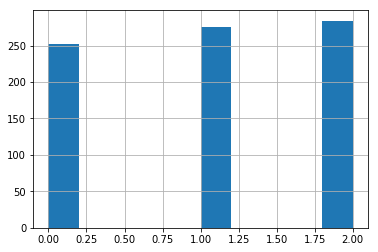

In [88]:
train_30_Y.hist()
plt.show()